# Energy savings on singlecell bayesian digital twin


# Prerequisite

### Sample data set

Unpack the sample data set present at `notebooks/data/sim_data.zip` under `notebooks/data/`


In [1]:
import sys
from pathlib import Path
sys.path.append(f"{Path().absolute().parent}")

#### Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds.

Hence will test results using same bayesian digitaltwin but 2 different EnergySavingsGym object and match the results

In [2]:
from radp.utility.simulation_utils import seed_everything
seed_everything(1)

In [3]:
import numpy as np
from scipy import stats
from scipy.ndimage import correlate
from skimage.metrics import structural_similarity as ssim
from radp_library import *

## Using pregenerated data stored locally
Currently the data is stored under notebooks

/data folder

In [4]:
WORKING_DIR = f"{Path().absolute()}"
BUCKET_PATH = f"{WORKING_DIR}/data"
SIM_DATA_PATH = "sim_data/3cell"

## Bayesian digital twin training

In [5]:
# provide list of folder name under which the pregenerated data is stored
sim_idx_folders = ['sim_001', 'sim_002', 'sim_003', 'sim_004', 'sim_005']

[2024-07-25 12:25:52,849] INFO:  Iter 1/5 - Loss: 0.825 (delta=inf)
[2024-07-25 12:25:52,975] INFO:  Iter 2/5 - Loss: 0.805 (delta=-0.019514)
[2024-07-25 12:25:53,099] INFO:  Iter 3/5 - Loss: 0.786 (delta=-0.019419)
[2024-07-25 12:25:53,228] INFO:  Iter 4/5 - Loss: 0.767 (delta=-0.019335)
[2024-07-25 12:25:53,358] INFO:  Iter 5/5 - Loss: 0.747 (delta=-0.019322)
[2024-07-25 12:25:53,504] INFO:  Iter 1/5 - Loss: 0.825 (delta=inf)
[2024-07-25 12:25:53,631] INFO:  Iter 2/5 - Loss: 0.806 (delta=-0.018933)
[2024-07-25 12:25:53,762] INFO:  Iter 3/5 - Loss: 0.788 (delta=-0.018166)
[2024-07-25 12:25:53,890] INFO:  Iter 4/5 - Loss: 0.769 (delta=-0.019679)
[2024-07-25 12:25:54,023] INFO:  Iter 5/5 - Loss: 0.750 (delta=-0.018380)
[2024-07-25 12:25:54,196] INFO:  Iter 1/5 - Loss: 0.825 (delta=inf)
[2024-07-25 12:25:54,330] INFO:  Iter 2/5 - Loss: 0.805 (delta=-0.019516)
[2024-07-25 12:25:54,466] INFO:  Iter 3/5 - Loss: 0.786 (delta=-0.019194)
[2024-07-25 12:25:54,602] INFO:  Iter 4/5 - Loss: 0.767 

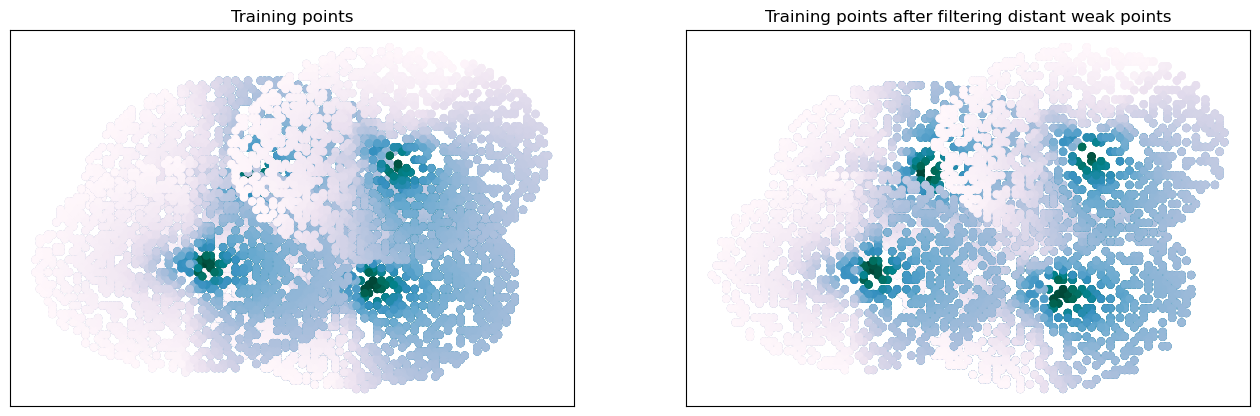

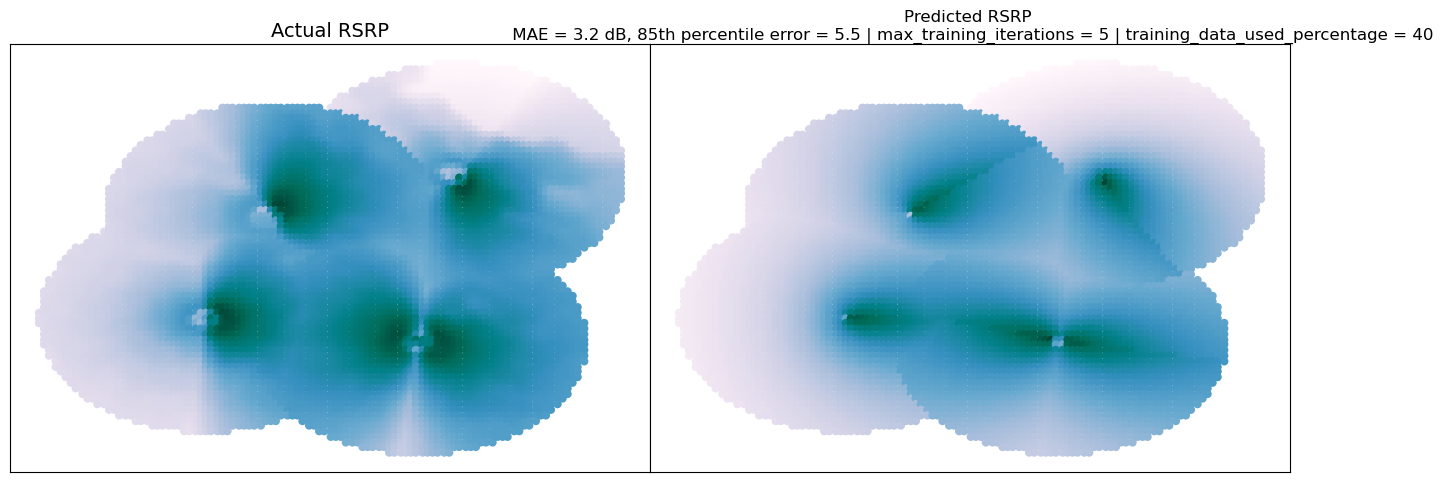

In [6]:
p_train_maxiter_dict = {
        40: [5]
}
p_test = 100

bayesian_digital_twins_list = []
test_data_list = []
pred_rsrp_list = []
MAE_list = []
Percentile85Error_list = []
p_train_list = []
maxiter_list = []


for p_train in p_train_maxiter_dict.keys():
    for maxiter in p_train_maxiter_dict[p_train]:
        logging.info(f"\n\nMAXITER = {maxiter}, p_train={p_train}\n")
        bayesian_digital_twins, site_config_df, test_data, loss_vs_iter, lons, lats, true_rsrp, pred_rsrp, MAE, Percentile85Error = bdt(
            bucket_path=BUCKET_PATH,
            sim_data_path=SIM_DATA_PATH,
            p_train=p_train,
            p_test=p_test,
            maxiter=maxiter,
            sim_idx_folders=sim_idx_folders,
            test_idx=2,
            plot_loss_vs_iter=True,
            choose_strongest_samples_percell=False,
            filter_out_samples_dbm_threshold=-70,
            filter_out_samples_kms_threshold=0.65,
        )
        bayesian_digital_twins_list.append(bayesian_digital_twins)
        test_data_list.append(test_data)
        p_train_list.append(p_train)
        maxiter_list.append(maxiter)
        pred_rsrp_list.append(pred_rsrp)
        MAE_list.append(MAE)
        Percentile85Error_list.append(Percentile85Error)


## Construct EnergySavings OpenAI Gym object

In [7]:
!pip install gym

In [8]:
from apps.energy_savings.energy_savings_gym import EnergySavingsGym
energy_savings_gym = EnergySavingsGym(
    bayesian_digital_twins={1:bayesian_digital_twins_list[0][1]},
    site_config_df=site_config_df[site_config_df.cell_id.isin([1])].reset_index(),
    prediction_frame_template={1:test_data_list[0][1]},
    tilt_set=[0, 1],
)

## Run a few iterations of Energy Savings OpenAI gym steps

In [9]:
import time
iterations = 100

In [10]:
start = time.time()
expected_rewards = []
for _i in range(iterations):
    # Sample a random action from the entire action space
    random_action = energy_savings_gym.action_space.sample()
    # Take the action and get the new observation
    new_obs, reward, done, info = energy_savings_gym.step(random_action)
    expected_rewards.append(reward)
    print(reward)
end = time.time()
print(f"Finished {iterations} iterations in {(end - start)} seconds!")

-2.097367695119331
-2.03081576554089
-2.03081576554089
-2.03081576554089
-25.0
-25.0
-2.097367695119331
-25.0
-2.097367695119331
-25.0
-25.0
-2.03081576554089
-25.0
-2.03081576554089
-25.0
-2.03081576554089
-25.0
-2.097367695119331
-2.03081576554089
-2.097367695119331
-2.03081576554089
-2.03081576554089
-25.0
-2.097367695119331
-2.097367695119331
-2.097367695119331
-25.0
-25.0
-25.0
-2.097367695119331
-25.0
-2.097367695119331
-2.03081576554089
-25.0
-2.097367695119331
-2.03081576554089
-2.097367695119331
-25.0
-25.0
-2.097367695119331
-2.097367695119331
-2.03081576554089
-2.097367695119331
-2.097367695119331
-2.097367695119331
-25.0
-2.03081576554089
-2.097367695119331
-2.03081576554089
-25.0
-25.0
-2.03081576554089
-25.0
-2.03081576554089
-2.097367695119331
-2.03081576554089
-2.097367695119331
-25.0
-2.03081576554089
-2.03081576554089
-2.097367695119331
-2.03081576554089
-2.03081576554089
-2.097367695119331
-2.03081576554089
-25.0
-2.03081576554089
-25.0
-2.097367695119331
-2.03081576

## Reproducbility test
Generate reproducible results using identical seeds which was set at the begining of the notebook using seed_everything(1)

In [11]:
energy_savings_gym = EnergySavingsGym(
    bayesian_digital_twins={1:bayesian_digital_twins_list[0][1]},
    site_config_df=site_config_df[site_config_df.cell_id.isin([1])].reset_index(),
    prediction_frame_template={1:test_data_list[0][1]},
    tilt_set=[0, 1],
)

In [12]:
start = time.time()
rewards = []

for _i in range(iterations):
    # Sample a random action from the entire action space
    random_action = energy_savings_gym.action_space.sample()
    # Take the action and get the new observation
    new_obs, reward, done, info = energy_savings_gym.step(random_action)
    rewards.append(reward)
    print(reward)
end = time.time()
print(f"Finished {iterations} iterations in {(end - start)} seconds!")

-2.097367695119331
-2.03081576554089
-2.03081576554089
-2.03081576554089
-25.0
-25.0
-2.097367695119331
-25.0
-2.097367695119331
-25.0
-25.0
-2.03081576554089
-25.0
-2.03081576554089
-25.0
-2.03081576554089
-25.0
-2.097367695119331
-2.03081576554089
-2.097367695119331
-2.03081576554089
-2.03081576554089
-25.0
-2.097367695119331
-2.097367695119331
-2.097367695119331
-25.0
-25.0
-25.0
-2.097367695119331
-25.0
-2.097367695119331
-2.03081576554089
-25.0
-2.097367695119331
-2.03081576554089
-2.097367695119331
-25.0
-25.0
-2.097367695119331
-2.097367695119331
-2.03081576554089
-2.097367695119331
-2.097367695119331
-2.097367695119331
-25.0
-2.03081576554089
-2.097367695119331
-2.03081576554089
-25.0
-25.0
-2.03081576554089
-25.0
-2.03081576554089
-2.097367695119331
-2.03081576554089
-2.097367695119331
-25.0
-2.03081576554089
-2.03081576554089
-2.097367695119331
-2.03081576554089
-2.03081576554089
-2.097367695119331
-2.03081576554089
-25.0
-2.03081576554089
-25.0
-2.097367695119331
-2.03081576

In [13]:
print(rewards==expected_rewards)

True
